# 1622 Group Course Project

## Import Library 

In [ ]:
#!pip install ibm_watson --upgrade

import os
from glob import glob
from bs4 import BeautifulSoup
import IPython
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson import SpeechToTextV1
from ibm_watson import AssistantV2
from ibm_watson import TextToSpeechV1

import pandas as pd
import yfinance as yf
import datetime
import numpy as np
import cvxpy as cp
import cplex 
import random
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import scipy

## Connect to Watson Assistant

In [ ]:
assistant = AssistantV2(version='2021-11-27', authenticator=IAMAuthenticator('4B8vQ5Tk3CmE-yGDtHD4JTMR654GjsKAMDzHfqe2BYHG'))
assistant.set_service_url('https://api.us-south.assistant.watson.cloud.ibm.com/instances/3a5c4865-0b19-40bc-91d2-7f539d5261f0')
ASSISTANT_ID = "50e62868-22dc-43ed-a209-4bcbdd7dde60"
session_id = assistant.create_session(assistant_id=ASSISTANT_ID).get_result()["session_id"]

def message_assistant(text):
    response = assistant.message(assistant_id=ASSISTANT_ID,
                                 session_id=session_id,
                                 input={'message_type': 'text', 'text': text}).get_result()
    return BeautifulSoup(response["output"]["generic"][0]["text"]).get_text()

## Collect Conversational Inputs

In [ ]:
message_assistant('I want to invest')

'What is the amount of fund you want to invest? (Please enter a number)'

In [ ]:
cash = input()
message_assistant(cash)

10000


'How long do you want to hold? (Please input the number in days and the range is in 2 to 100)'

In [ ]:
period = input()
message_assistant(period)

50


'Is there any preference in assets choice?'

In [ ]:
choice = input()
message_assistant(choice)

No


'We will choose a combination of assets for you. Is that fine to you?'

In [ ]:
message_assistant('Yes')

"What's your investing preference?"

In [ ]:
stock_list = input()
message_assistant(stock_list)

"I'm sorry, I did not catch that, please restate your response."

In [ ]:
preference = input()
message_assistant(preference)

Low risk, Low return


'Please wait, we are calculating the best portfolio that suits your need.\nLoading...'

In [ ]:
cash = float(cash)

period = int(period)

if choice == 'Yes':
    stock_list = stock_list.split(',')
if choice == 'No':
    stock_list = ['SPY','VTV','VUG','GOVT','EEMV','CBOE','QQQ']
print('We have selected the following stocks {}'.format(stock_list))

We have selected the following stocks ['SPY', 'VTV', 'VUG', 'GOVT', 'EEMV', 'CBOE', 'QQQ']


## Investment Strategy

In [ ]:
class Orion:
    def __init__(self, cash, period, choice, preference, stock_list):
        self.cash = cash
        self.period = period
        self.choice = choice
        self.preference = preference
        self.stock_list = stock_list
        
    def get_result(self):
    
    #date setting
        end_date = datetime.date.today()
        start_date=datetime.date.today() - datetime.timedelta(days=2*365)
    
    # Fetch the data
        data= yf.download(self.stock_list,start_date,end_date)['Adj Close']
    
    #create dataframe
        df = pd.DataFrame(data)

    #Calculate monthly return as percent change of monthly closing values, reset indices 
        ret = df.pct_change().iloc[1:,:]
        ret.reset_index(inplace = True, drop = True)

    # Compute the covariance matrix of the percent change of prices
        Q = ret.cov().to_numpy()

    # Compute the mean for each column 
        mu = np.array(np.mean(ret, axis = 0))

    # Store number of features 
        n = ret.shape[1] 
    
        if self.preference == "Low risk, Low return":
            w1 = cp.Variable(n)

        # Form the problem , minimize
            constraints1 = [sum(w1) == 1,w1 >= 0]
            prob1 = cp.Problem(cp.Minimize(cp.quad_form(w1, Q)) , constraints1)

        #Solve Problem
            prob1.solve(verbose=False)

            W = w1.value #solution value: minimum variance 
        #store the return and variance of Min variance profolio

        
        elif self.preference == "Medium risk, Medium return": 
            n=n+1
            cpx = cplex.Cplex()
            cpx.objective.set_sense(cpx.objective.sense.minimize)
            r_rf = 0.025
            lb = np.zeros((n))
            c=np.zeros((n))
            ub = [np.inf]*n
            names = ['y'+str(i) for i in range(1,n+1)]

            diff= mu-(r_rf/252)*np.ones(n-1)

            A=[]
            for k in range(n-1):
                A.append([[0,1],[diff[k],1.0]])
            A.append([[0,1],[0,-1]])

            cpx.linear_constraints.add(rhs=[1,0], senses="EE")
            cpx.variables.add(obj = c, lb = lb, ub = ub, columns= A, names = names) 


            #Q_sharp=np.append(Q,np.zeros((n-1,1)),axis=1)
            #Q_sharp=np.append(Q_sharp,np.zeros((1,n)),axis=0)
            Q_sharp = np.append(Q,np.zeros((n-1,1)),axis=1)
            Q_sharp = np.vstack([Q_sharp,np.zeros((n))])
            Qmat = [[list(range(n)), list(2*Q_sharp[k,:])] for k in range(n)]
            cpx.objective.set_quadratic(Qmat)
            cpx.parameters.threads.set(6)
            cpx.set_results_stream(None)
            cpx.set_warning_stream(None)
            cpx.solve()
            W = np.array(cpx.solution.get_values()[:-1])/np.array(cpx.solution.get_values()[-1])


        
        elif self.preference == "High risk, High return":
            w2 = cp.Variable(n)

            constraints2 = [sum(w2) == 1, w2 >= 0]
            prob2 = cp.Problem(cp.Maximize(mu.T@w2), constraints2)
                     
        # Solve the problem 
            prob2.solve(verbose=False)

            W = w2.value #solution value: maximum expected return
        
        df_w = pd.DataFrame([np.round(W*self.cash,2).tolist()], columns = stock_list, index=['Cash Allocation'])
        print('-------------------------------')
        print('Cash allocation:\n',df_w)

    #Simulation
        if self.preference == "Medium risk, Medium return":
            n = n-1
        capital = self.cash
        Ns = 100000 # Number of scenarios
        days = self.period
        ret_matrix=np.ones((n,Ns))
        scenarios = np.random.multivariate_normal(mu, Q, Ns)
        for i in range(n):
            for day in range(1, days+1):
                ret_matrix[i,:] *= (1 + scenarios[:,i])
        
        V= capital*np.dot(W,ret_matrix)
        
        V_sort=sorted(V)
        perc5=V_sort[int(Ns * 0.05)]
        perc95=V_sort[int(Ns * 0.95)]
        V_new = V_sort[int(Ns * 0.1):int(Ns * 0.9)]
        
    # Visualization
    
        d = {'Col1': ['Number of values', 'Mean', 'Standard deviation','Skewness', 'kurtosis','5% Perc', '95% Perc', 'Minimum','Maximum'],
     'Col2': [Ns,np.mean(V),np.std(V), stats.describe(V)[4],stats.describe(V)[5], perc5,perc95, V_sort[0],V_sort[-1]]}

        df = pd.DataFrame(data=d)
        print('\n-------------------------------')
        print('Return summary:\n',df)
        '''
        sns.set()
        plt.figure(figsize=(8, 6), dpi=80)
        frequencyCounts, binLocations, patches = plt.hist(V, 50)
        plt.plot([perc5,perc5],[0,max(frequencyCounts)],color='black', linewidth=1, linestyle='-.', label ='5% Perc')
        plt.plot([perc95,perc95],[0,max(frequencyCounts)],color='r', linewidth=1, linestyle='-.', label ='95% Perc')
        #plt.yscale('log')
        plt.xlabel('portfolio value')
        plt.ylabel('frequency')
        plt.title('Total Value')
        plt.legend()
        plt.show()
        '''
        fig, axs = plt.subplots(2)
        fig.suptitle('Distributions of Total Returns')
        fig.set_size_inches(16, 10)
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)
        
        frequencyCounts, binLocations, patches = axs[0].hist(V, 100)
        axs[0].plot([perc5,perc5],[0,max(frequencyCounts)],color='black', linewidth=1, linestyle='-.', label ='5% Perc')
        axs[0].plot([perc95,perc95],[0,max(frequencyCounts)],color='r', linewidth=1, linestyle='-.', label ='95% Perc')
        axs[1].hist(V_new, 50)
        axs[0].set_title('Total Returns')
        axs[1].set_title('10th Percentile to 90th Percentile Returns')
        axs[0].set_ylabel('Counts')
        axs[1].set_ylabel('Counts')
        plt.show()

        return df_w, df

[*********************100%***********************]  7 of 7 completed
-------------------------------
Cash allocation:
                     SPY     VTV     VUG  GOVT  EEMV    CBOE  QQQ
Cash Allocation  104.32  248.98  8431.7   0.0   0.0  1215.0  0.0

-------------------------------
Return summary:
                  Col1           Col2
0    Number of values  100000.000000
1                Mean   10328.178961
2  Standard deviation    1399.469008
3            Skewness       0.485311
4            kurtosis       0.592935
5             5% Perc    8219.326762
6            95% Perc   12770.989189
7             Minimum    5662.705922
8             Maximum   20581.713614


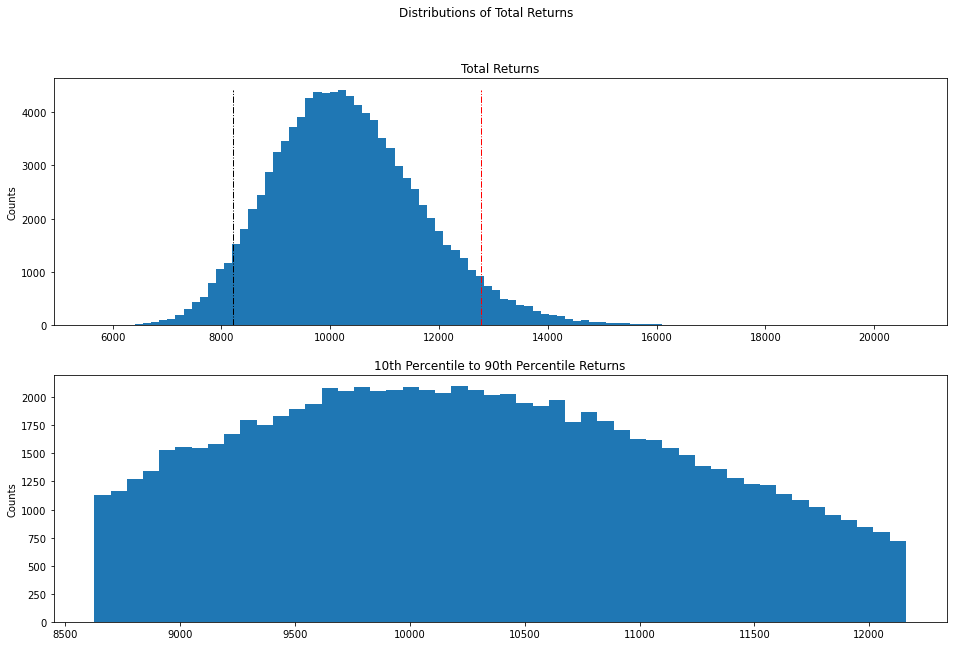

In [ ]:
### Low risk, Low return
CashPrportion, info = Orion(cash=cash, period=period, choice=choice, preference=preference, stock_list=stock_list).get_result()

[*********************100%***********************]  7 of 7 completed
-------------------------------
Cash allocation:
                  SPY  VTV  VUG     GOVT  EEMV     CBOE  QQQ
Cash Allocation  0.0  0.0  0.0  2084.79   0.0  7915.21  0.0

-------------------------------
Return summary:
                  Col1           Col2
0    Number of values  100000.000000
1                Mean   12323.422154
2  Standard deviation    6568.481143
3            Skewness       1.653890
4            kurtosis       4.938173
5             5% Perc    4724.021170
6            95% Perc   24763.388095
7             Minimum    1174.167419
8             Maximum   88053.117376


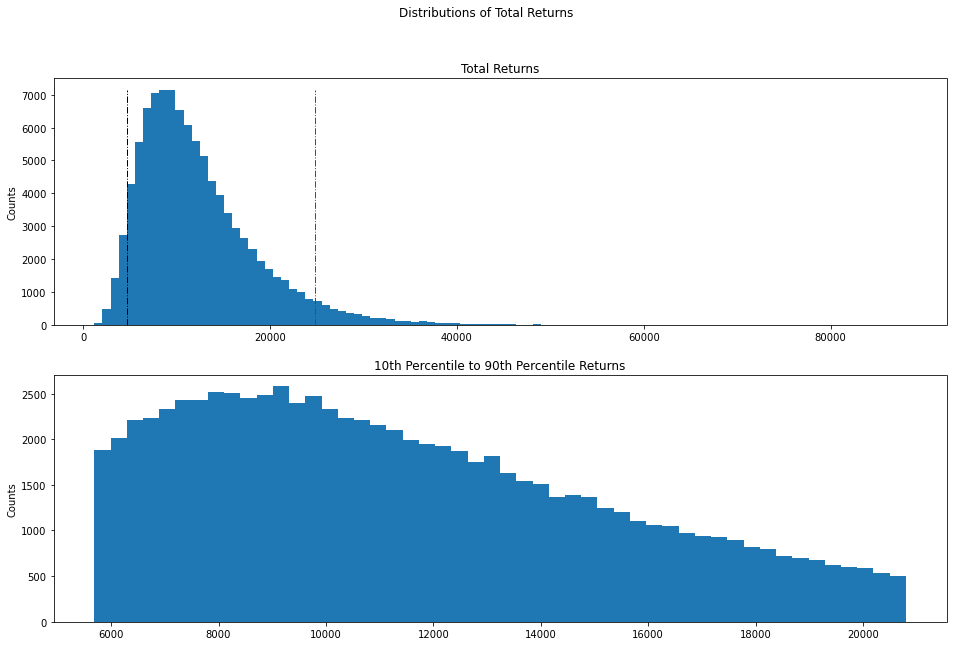

In [ ]:
### Medium risk, medium return
CashPrportion, info = Orion(cash=cash, period=period, choice=choice, preference='Medium risk, Medium return', stock_list=stock_list).get_result()

[*********************100%***********************]  7 of 7 completed
-------------------------------
Cash allocation:
                  SPY  VTV  VUG     GOVT  EEMV  CBOE  QQQ
Cash Allocation  0.0  0.0  0.0  9999.96   0.0  0.03  0.0

-------------------------------
Return summary:
                  Col1           Col2
0    Number of values  100000.000000
1                Mean   13488.521178
2  Standard deviation   10823.803546
3            Skewness       2.811773
4            kurtosis      16.162242
5             5% Perc    3210.549202
6            95% Perc   33717.136347
7             Minimum     460.969287
8             Maximum  199594.896861


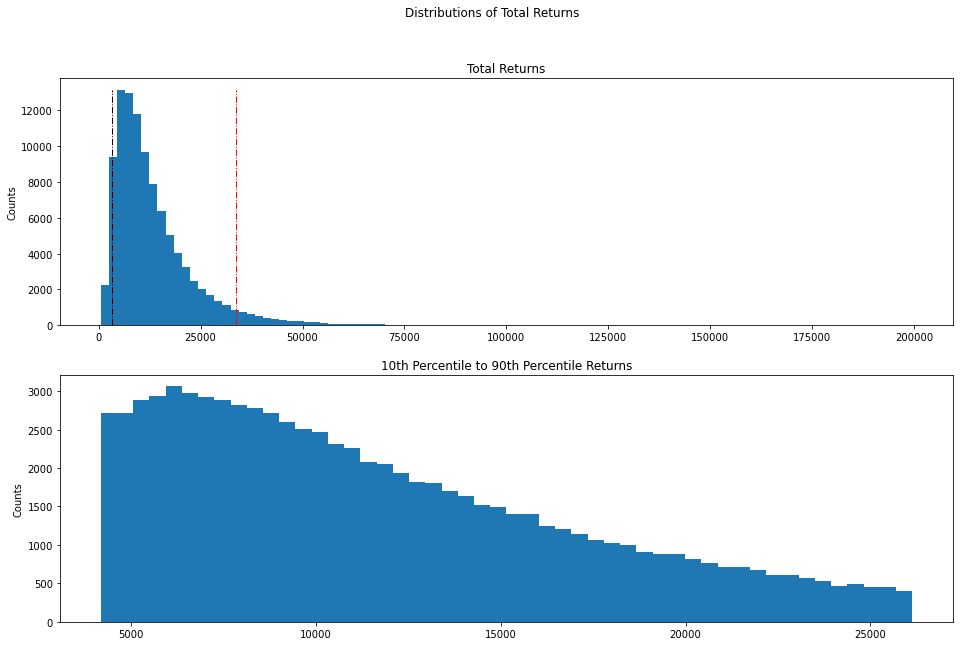

In [ ]:
### High risk, high return
CashPrportion, info = Orion(cash=cash, period=period, choice=choice, preference='High risk, High return', stock_list=stock_list).get_result()